# Loading pytorch and necessary libraries

In [36]:
import numpy as np
import pandas as pd
import cv2, os
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models, datasets

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading the train, test and prediction datasets

In [38]:
#Defining the Directories

train_data_dir = "/content/drive/MyDrive/BRTcom/Training"
test_data_dir = "/content/drive/MyDrive/BRTcom/Testing"
pred_data_dir = "/content/drive/MyDrive/BRTcom/pred"

# Checking the number of images per class in train and test dataset

In [39]:
#Checking the number of Train Images

for i in os.listdir(train_data_dir):
    new_loc = os.path.join(train_data_dir,i)
    new = new_loc + '/*.jpg'
    images = glob(new)
    print(f'{i}:',len(images))

pituitary: 1457
glioma: 1321
meningioma: 1349
notumor: 1595


In [40]:
#Checking the number of Test Images

for i in os.listdir(test_data_dir):
    new_loc = os.path.join(test_data_dir,i)
    new = new_loc + '/*.jpg'
    images = glob(new)
    print(f'{i}:',len(images))

pituitary: 300
meningioma: 306
glioma: 300
notumor: 405


**Getting the classes and their meaning in a dictionary**

In [41]:
# Getting the classes and their meaning in a dictionary
classes = os.listdir(train_data_dir)
classes = {k: v for k,v in enumerate(sorted(classes))}
print(classes)

{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


# Defining the Image transformation and Data augmentation on the train and validation dataset

In [42]:
# Performing the Image Transformation and Data Augmentation on the
# train dataset and transformation on Validation Dataset

# convert data to a normalized torch.FloatTensor

transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(0.3,0.4,0.4,0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.425,0.415,0.405),(0.205,0.205,0.205))
])

# Augmentation on test images not needed
transform_tests = torchvision.transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

# Loading Images from train, test, validation directories

In [43]:
# using ImageFolder function for fetching data from directory
train_data = datasets.ImageFolder(root=train_data_dir,transform=transform)
test_data = datasets.ImageFolder(root=test_data_dir,transform=transform_tests)

training_data = DataLoader(train_data,batch_size=32,drop_last=True,shuffle=True,num_workers=2)
validation_data = DataLoader(test_data, batch_size =32, drop_last=True,shuffle=True,num_workers=2)

# Printing Image data from training dataset

torch.Size([3, 300, 300])
-------------
0
Class:  glioma


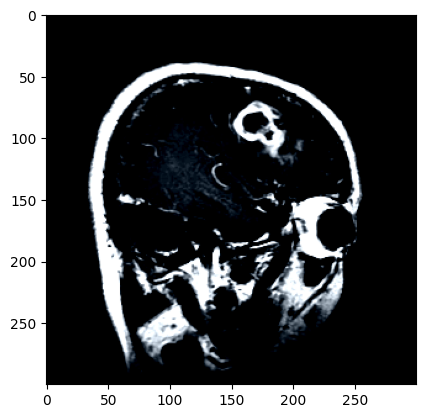

In [44]:
# Random checking of train images
im, label = train_data[1000]
print(im.shape)
print("-------------")
print(label)
plt.imshow(im.permute(1,2,0).cpu())
print("Class: ",classes[label])

Class: glioma


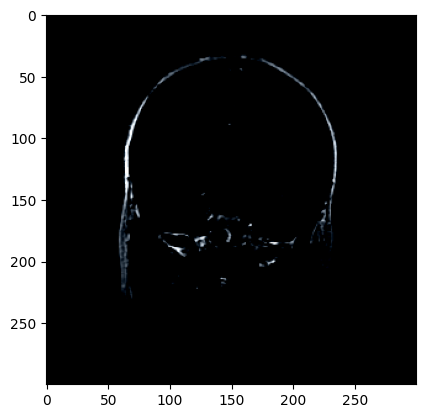

In [45]:
im, label = train_data[500]
plt.imshow(im.permute(1,2,0).cpu())
print('Class:',classes[label])

Class: pituitary


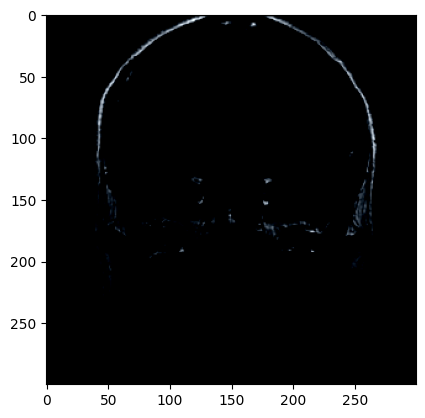

In [46]:
im, label = train_data[5000]
plt.imshow(im.permute(1,2,0).cpu())
print('Class:',classes[label])

# Using InceptionV3 with its pretrained weights

In [47]:
#Downloading the InceptionV3 Model with their pretrained weights

model = models.inception_v3(pretrained=True)
model.parameters

<bound method Module.parameters of Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2

# Defining the Model function

In [48]:
#Defining the Model Function.
# Lets freeze all layers and change just a few layers to match our requirements

def get_model():
    model = models.inception_v3(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False #Freezing all the layers and changing only the below layers
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
                            nn.Linear(2048,128),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(128,6))
    model.aux_logits = False
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

In [49]:
!pip install torchsummary

# Printing the InceptionV3 model architecture

In [50]:
from torchsummary import summary

input_shape = (3,300,300)
summary(model.to(device), input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

**Defining the Utility function to get the Losses and accuracies for train and validation dataset**

In [51]:
#Creating the Utlity function to get the Losses and Accuracies for Train and Validation Dataset

def train_batch(x, y, model, opt, loss_fn):
    output = model(x)
#     print(f"type of output - {type(output)}")
    batch_loss = loss_fn(output, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

# Initializing and training the model

In [52]:
#Initializing the Model, Loss Fuction and Optimizer to a Variable

model, loss_fn, optimizer = get_model()

In [53]:
# Start the Model Training and save the Losses and Accuracies of Both train and validation

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(20):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(training_data)):
#         print(f"ix - {ix}, {batch}")
        x, y = batch
#         print(f"type of x - {type(x)}, type of y - {type(y)}")
        x, y= x.to(device), y.to(device)
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    print('Epoch:',epoch,'Train Loss:',train_epoch_loss,'Train Accuracy:',train_epoch_accuracy)

    for ix, batch in enumerate(iter(validation_data)):
        x, y = batch
        x, y= x.to(device), y.to(device)
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
        val_epoch_accuracy = np.mean(val_is_correct)

    print('Epoch:',epoch,'Validation Loss:',validation_loss,'Validation Accuracy:',val_epoch_accuracy)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
Epoch: 0 Train Loss: 0.49566764417993886 Train Accuracy: 0.8330407303370787
Epoch: 0 Validation Loss: 0.5154644846916199 Validation Accuracy: 0.84375
1
Epoch: 1 Train Loss: 0.3147372610532166 Train Accuracy: 0.8932584269662921
Epoch: 1 Validation Loss: 0.46459588408470154 Validation Accuracy: 0.8125
2
Epoch: 2 Train Loss: 0.26625719725081093 Train Accuracy: 0.9115168539325843
Epoch: 2 Validation Loss: 0.6474859714508057 Validation Accuracy: 0.71875
3
Epoch: 3 Train Loss: 0.22668945611444083 Train Accuracy: 0.9262640449438202
Epoch: 3 Validation Loss: 0.31725576519966125 Validation Accuracy: 0.875
4
Epoch: 4 Train Loss: 0.19511680993554967 Train Accuracy: 0.9362710674157303
Epoch: 4 Validation Loss: 0.18807339668273926 Validation Accuracy: 0.9375
5
Epoch: 5 Train Loss: 0.17858510159918767 Train Accuracy: 0.9431179775280899
Epoch: 5 Validation Loss: 0.2776961922645569 Validation Accuracy: 0.90625
6
Epoch: 6 Train Loss: 0.17016737761624742 Train Accuracy: 0.9436446629213483
Epoch: 6 Val

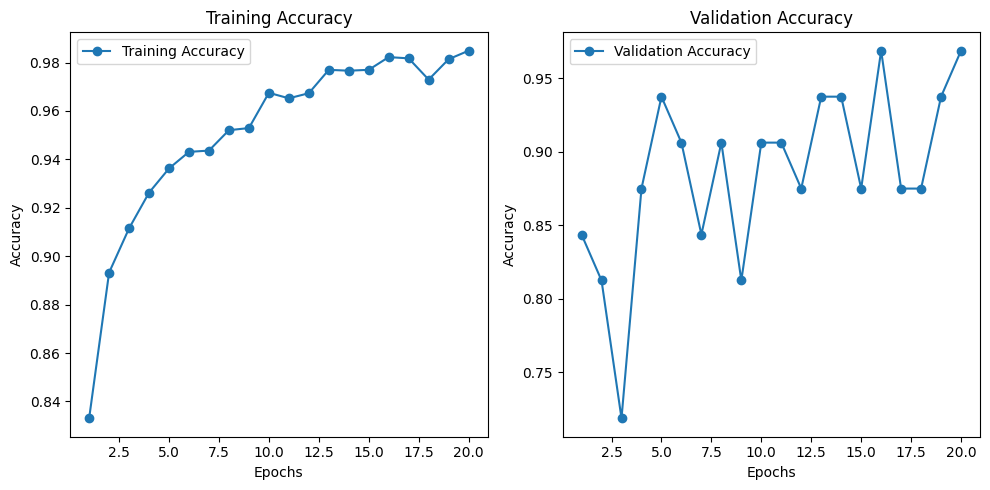

In [61]:


# Plotting training and validation accuracies
epochs = range(1, 21)  # Assuming 20 epochs
plt.figure(figsize=(10, 5))

# Plotting training accuracies
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting validation accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


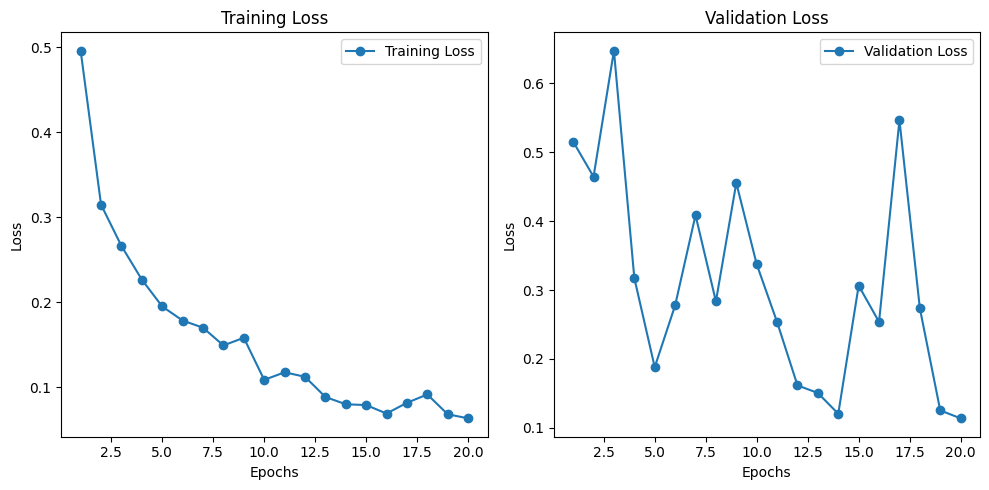

In [62]:

# Plotting training and validation losses
epochs = range(1, 21)  # Assuming 20 epochs
plt.figure(figsize=(10, 5))

# Plotting training losses
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting validation losses
plt.subplot(1, 2, 2)
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Using model to predict images from prediction set

In [63]:
#Lets define the function to predict the images from prediction set

from torch.autograd import Variable

def pred_class(img):
    # transform images
    img_tens = transform_tests(img)
    # change image format (3,300,300) to (1,3,300,300) by help of unsqueeze function
    # image needs to be in cuda before predition
    img_im = img_tens.unsqueeze(0).cuda()
    uinput = Variable(img_im)
    uinput = uinput.to(device)
    out = model(uinput)
    # convert image to numpy format in cpu and snatching max prediction score class index
    index = out.data.cpu().numpy().argmax()
    return index

In [64]:
#Lets get the location of all the prediction files
pred_files = [os.path.join(pred_data_dir, f) for f in os.listdir(pred_data_dir)]
pred_files[:10]

['/content/drive/MyDrive/BRTcom/pred/Copy of Te-no_0016 (1).jpg',
 '/content/drive/MyDrive/BRTcom/pred/Copy of Te-no_0012 (1).jpg',
 '/content/drive/MyDrive/BRTcom/pred/Copy of Te-no_0013 (1).jpg',
 '/content/drive/MyDrive/BRTcom/pred/Copy of Te-no_0011 (1).jpg',
 '/content/drive/MyDrive/BRTcom/pred/Copy of Te-no_0010 (1).jpg',
 '/content/drive/MyDrive/BRTcom/pred/Copy of Te-no_0015 (1).jpg',
 '/content/drive/MyDrive/BRTcom/pred/Copy of Te-no_0017 (1).jpg',
 '/content/drive/MyDrive/BRTcom/pred/Copy of Te-no_0018 (1).jpg',
 '/content/drive/MyDrive/BRTcom/pred/Copy of Te-no_0019.jpg',
 '/content/drive/MyDrive/BRTcom/pred/Copy of Te-no_0014 (1).jpg']

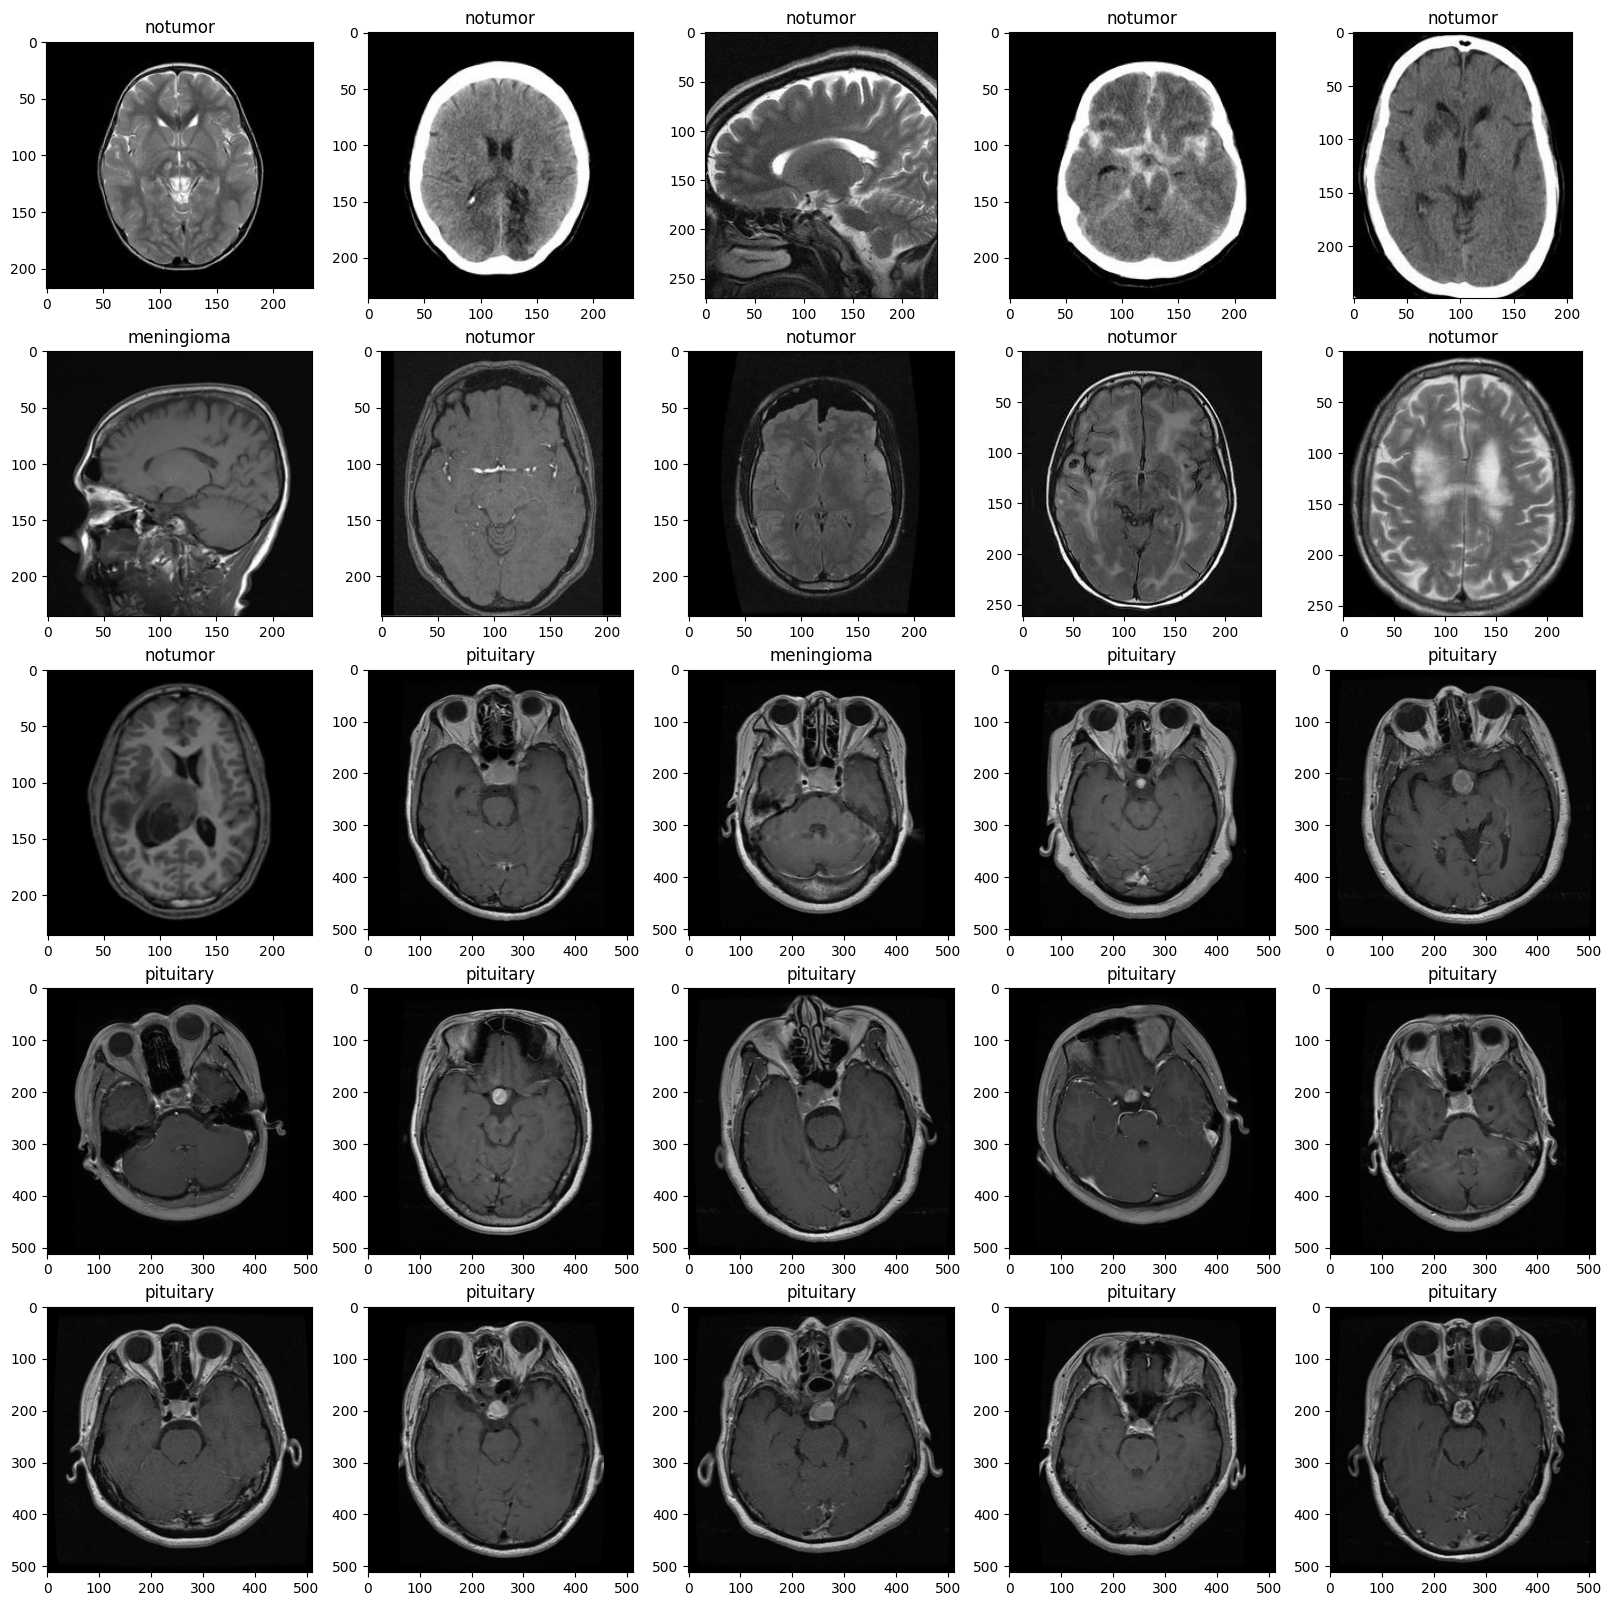

In [65]:
#Prediction Results

model.eval()

plt.figure(figsize=(20,20))
for i, images in enumerate(pred_files):
    # just want 25 images to print
    if i > 24:break
    img = Image.open(images)
    index = pred_class(img)
    plt.subplot(5,5,i+1)
    plt.title(classes[index])
    plt.axis('on')
    plt.imshow(img)